In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_columns', None)

# Table of content

- [EDA](#EDA)
    - [1.1 Data-preproceeing](#11Data-preproceeing)
    - [1.2 feature classification](#12featureclassification)
    - [1.4 sumarry](#14sumarry)

In [73]:
df = pd.read_csv("../../data/raw/wwlLancMsc_data.csv")
df.shape
df.head()

df = pd.read_csv("../../data/raw/wwlLancMsc_data.csv", low_memory=False)
df_my = df.iloc[:, -20:]
print("Selected columns:\n", list(df_my.columns))
df_my.head()

df_my.info()
df_my.describe()
df_my.isna().sum()
missing = df_my.isna().mean() * 100
missing = missing.sort_values(ascending=False)
print(missing)


empty_cols = [c for c in df_my.columns if df_my[c].isna().sum() == len(df_my)]
print("Completely empty columns:", empty_cols)

/var/folders/vw/3ry2l6hs6qz2yjr9tcj8bq6c0000gp/T/ipykernel_18830/642379094.py:1: DtypeWarning: Columns (58) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../../data/raw/wwlLancMsc_data.csv")


Selected columns:
 ['chronic_condition_obesity_flag', 'chronic_condition_respiratory_flag', 'frailty_score', 'Arrival_Date', 'arrival_date_time', 'attendancetype', 'initial_assessment_date_time', 'sex_description.y', 'arrival_mode_description', 'place_of_incident', 'source_of_ref_description', 'presenting_complaint', 'acuity_code', 'inj_or_ail', 'NEWS2', 'attend_dis_description', 'ae_unplanned_attendance', 'location', 'ID', 'Deprivation Decile']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41846 entries, 0 to 41845
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   chronic_condition_obesity_flag      41846 non-null  int64  
 1   chronic_condition_respiratory_flag  41846 non-null  int64  
 2   frailty_score                       41846 non-null  object 
 3   Arrival_Date                        11464 non-null  object 
 4   arrival_date_time                   11464 non-

['chronic_condition_obesity_flag', 'chronic_condition_respiratory_flag', 'sex_description.y', 'inj_or_ail']

sex_description.y:
[nan  0.  1.]

inj_or_ail:
[nan  0.  1.]


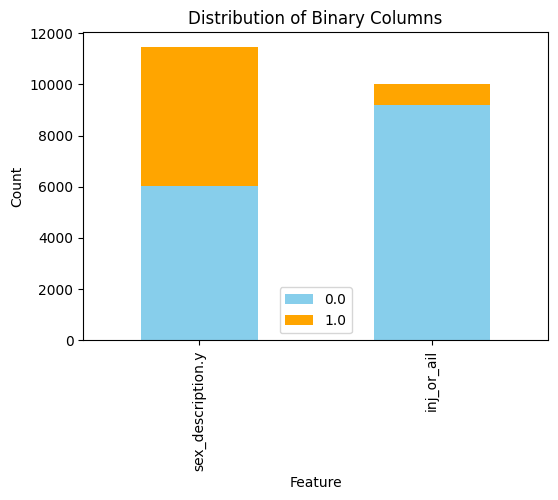

In [ ]:
binary_cols = [col for col in df_my.columns if df_my[col].nunique() == 2]
print(binary_cols)
df_my[binary_cols].dtypes
df_my[binary_cols] = df_my[binary_cols].fillna(0)


df_my["sex_description.y"] = df_my["sex_description.y"].replace(["NA", 0], np.nan)
df_my["inj_or_ail"] = df_my["inj_or_ail"].replace(["NA", 0], np.nan)

df_my["sex_description.y"] = df_my["sex_description.y"].map({"Male": 1, "Female": 0})
df_my["inj_or_ail"] = df_my["inj_or_ail"].map({"Injury": 1, "Ailment": 0})

for col in ["sex_description.y", "inj_or_ail"]:
    print(f"\n{col}:")
    print(df_my[col].unique())

df_my[["sex_description.y", "inj_or_ail"]].astype("category").apply(lambda x: x.value_counts()).T.plot(
    kind="bar", stacked=True, figsize=(6,4), color=["skyblue", "orange"]
)
plt.title("Distribution of Binary Columns")
plt.ylabel("Count")
plt.xlabel("Feature")
plt.show()


[ 2.  6.  4.  8. 10.  3.  5.  7.  1.  9.]
count    41846.000000
mean         5.040530
std          2.856262
min          1.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         10.000000
Name: frailty_score, dtype: float64


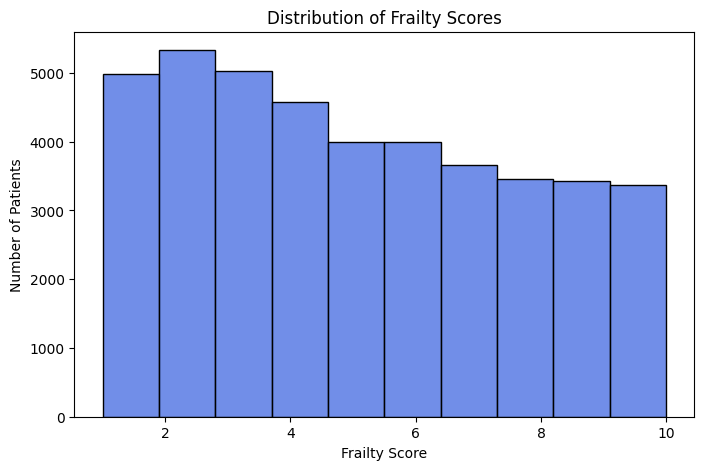

In [10]:
df_my["frailty_score"] = (
    df_my["frailty_score"]
    .astype(str)                
    .str.extract(r"(\d+)")     
    .astype(float)             
)

print(df_my["frailty_score"].unique())
print(df_my["frailty_score"].describe())

df_my["frailty_score"].dtype
plt.figure(figsize=(8,5))
sns.histplot(df_my["frailty_score"], bins=10, kde=False, color="royalblue")
plt.title("Distribution of Frailty Scores")
plt.xlabel("Frailty Score")
plt.ylabel("Number of Patients")
plt.show()

In [29]:
import pandas as pd
import numpy as np

df_my["Arrival_Date"] = pd.to_datetime(df_my["Arrival_Date"], errors="coerce")

raw = pd.read_csv(
    "../../data/raw/wwlLancMsc_data.csv",
    usecols=["arrival_date_time"],
    dtype=str
).loc[df_my.index, "arrival_date_time"].astype(str).str.strip()


adt_dayfirst   = pd.to_datetime(raw, dayfirst=True,  errors="coerce")   
adt_monthfirst = pd.to_datetime(raw, dayfirst=False, errors="coerce") 

final = pd.Series(pd.NaT, index=df_my.index, dtype='datetime64[ns]')

mask_match_day = (
    df_my["Arrival_Date"].notna() & adt_dayfirst.notna() &
    (adt_dayfirst.dt.date == df_my["Arrival_Date"].dt.date)
)
final[mask_match_day] = adt_dayfirst[mask_match_day]

mask_match_month = (
    df_my["Arrival_Date"].notna() & adt_monthfirst.notna() &
    final.isna() &
    (adt_monthfirst.dt.date == df_my["Arrival_Date"].dt.date)
)
final[mask_match_month] = adt_monthfirst[mask_match_month]

remaining = final.isna()
final[remaining] = adt_dayfirst[remaining].combine_first(adt_monthfirst[remaining])

df_my["arrival_date_time"] = final

mismatch_df = df_my[
    df_my["Arrival_Date"].notna() &
    df_my["arrival_date_time"].notna() &
    (df_my["Arrival_Date"].dt.date != df_my["arrival_date_time"].dt.date)
]
print("Remaining mismatches:", len(mismatch_df))


Remaining mismatches: 0


Attendance Type

['Unknown' 'Majors' 'Resus' 'GP Streaming' 'Paeds' 'Minors' 'Other']
count       41846
unique          7
top       Unknown
freq        30382
Name: attendancetype, dtype: object
Label mapping: {'GP Streaming': np.int64(0), 'Majors': np.int64(1), 'Minors': np.int64(2), 'Other': np.int64(3), 'Paeds': np.int64(4), 'Resus': np.int64(5), 'Unknown': np.int64(6)}


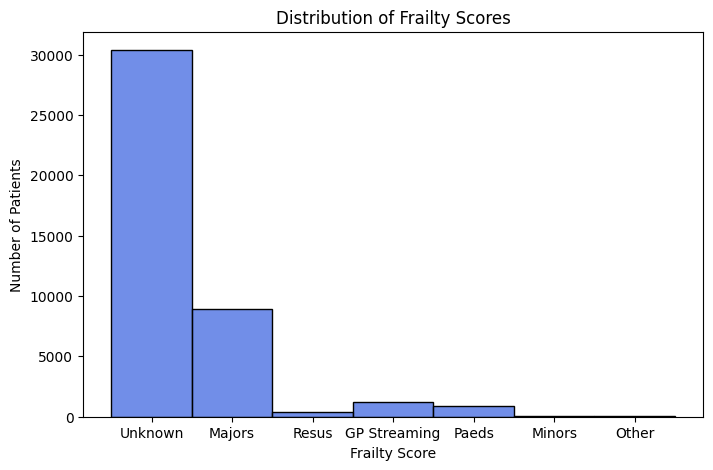

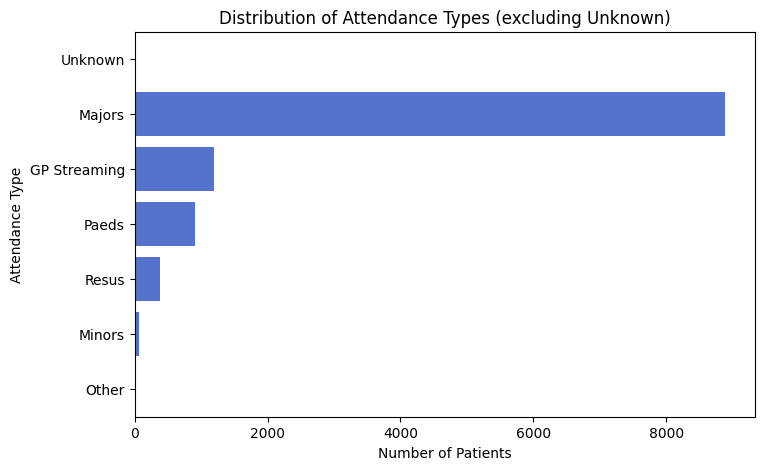

In [41]:

from sklearn.preprocessing import LabelEncoder

print(df_my["attendancetype"].unique())
print(df_my["attendancetype"].describe())

le = LabelEncoder()

df_my["attendancetype"] = df_my["attendancetype"].fillna("Unknown")

df_my["attendancetype_encoded"] = le.fit_transform(df_my["attendancetype"])

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", label_mapping)

df_my[["attendancetype", "attendancetype_encoded"]].head(10)

df_my["attendancetype"].dtype
plt.figure(figsize=(8,5))
sns.histplot(df_my["attendancetype"], bins=10, kde=False, color="royalblue")
plt.title("Distribution of Frailty Scores")
plt.xlabel("Frailty Score")
plt.ylabel("Number of Patients")
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(
    y="attendancetype",
    data=df_my[df_my["attendancetype"] != "Unknown"], 
    order=df_my["attendancetype"].value_counts().index,
    color="royalblue"
)
plt.title("Distribution of Attendance Types (excluding Unknown)")
plt.xlabel("Number of Patients")
plt.ylabel("Attendance Type")
plt.show()

initial_assessment_date_time

In [36]:
df_my["initial_assessment_date_time"] = pd.to_datetime(
    df_my["initial_assessment_date_time"], 
    errors="coerce",      
    dayfirst=True          
)

datetime64[ns]
0   NaT
1   NaT
2   NaT
3   NaT
4   NaT
Name: initial_assessment_date_time, dtype: datetime64[ns]


arrival_mode_description

[11  1  3  0 12  9  7  5 10  2  8  4  6 13]
count    41846.000000
mean         8.413301
std          4.364953
min          0.000000
25%          3.000000
50%         11.000000
75%         11.000000
max         13.000000
Name: arrival_mode_description, dtype: float64
Label mapping: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6), np.int64(7): np.int64(7), np.int64(8): np.int64(8), np.int64(9): np.int64(9), np.int64(10): np.int64(10), np.int64(11): np.int64(11), np.int64(12): np.int64(12), np.int64(13): np.int64(13)}


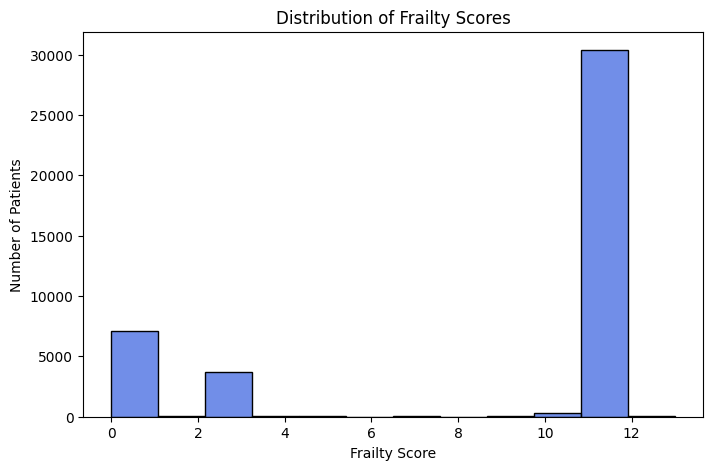

In [50]:
print(df_my["arrival_mode_description"].unique())
print(df_my["arrival_mode_description"].describe())

le = LabelEncoder()

df_my["arrival_mode_description"] = df_my["arrival_mode_description"].fillna("Unknown")

df_my["arrival_mode_description"] = le.fit_transform(df_my["arrival_mode_description"])

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", label_mapping)

df_my[["arrival_mode_description", "arrival_mode_description"]].head(10)

df_my["arrival_mode_description"].dtype
plt.figure(figsize=(8,5))
sns.histplot(df_my["arrival_mode_description"], bins=12, kde=False, color="royalblue")
plt.title("Distribution of Frailty Scores")
plt.xlabel("Frailty Score")
plt.ylabel("Number of Patients")
plt.show()

[15  3  7  8  2 11  9 12 16 13  1 10  0  5  4  6 14]
count    41846.000000
mean        11.951991
std          5.111547
min          0.000000
25%          8.000000
50%         15.000000
75%         15.000000
max         16.000000
Name: place_of_incident, dtype: float64
Label mapping: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6), np.int64(7): np.int64(7), np.int64(8): np.int64(8), np.int64(9): np.int64(9), np.int64(10): np.int64(10), np.int64(11): np.int64(11), np.int64(12): np.int64(12), np.int64(13): np.int64(13), np.int64(14): np.int64(14), np.int64(15): np.int64(15), np.int64(16): np.int64(16)}


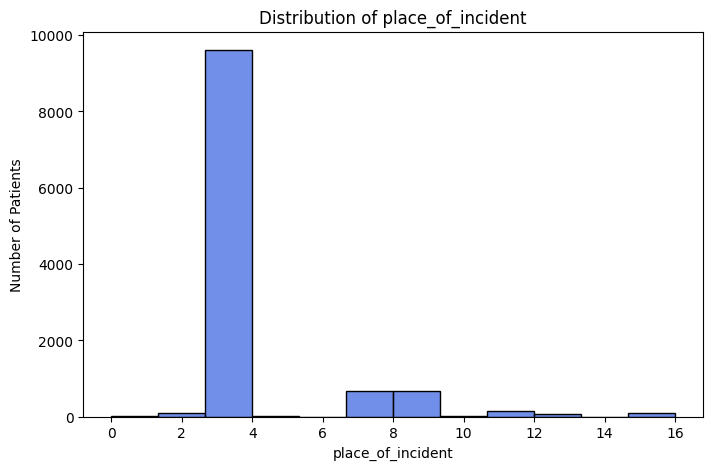

In [58]:
print(df_my["place_of_incident"].unique())
print(df_my["place_of_incident"].describe())

le = LabelEncoder()

df_my["place_of_incident"] = df_my["place_of_incident"].fillna("Unknown")

df_my["place_of_incident"] = le.fit_transform(df_my["place_of_incident"])

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", label_mapping)

df_my[["place_of_incident", "place_of_incident"]].head(10)

df_my["place_of_incident"].dtype
plt.figure(figsize=(8,5))
sns.histplot(
    df_my[df_my["place_of_incident"] != 15]["place_of_incident"], 
    bins=12,
    kde=False,
    color="royalblue"
)
plt.title("Distribution of place_of_incident")
plt.xlabel("place_of_incident")
plt.ylabel("Number of Patients")
plt.show()

[16 14  6  3  2  9 10 11  7 12 13  1  4 15  8  0  5]
count    41846.000000
mean        13.728385
std          4.544231
min          0.000000
25%         14.000000
50%         16.000000
75%         16.000000
max         16.000000
Name: source_of_ref_description, dtype: float64
Label mapping: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6), np.int64(7): np.int64(7), np.int64(8): np.int64(8), np.int64(9): np.int64(9), np.int64(10): np.int64(10), np.int64(11): np.int64(11), np.int64(12): np.int64(12), np.int64(13): np.int64(13), np.int64(14): np.int64(14), np.int64(15): np.int64(15), np.int64(16): np.int64(16)}


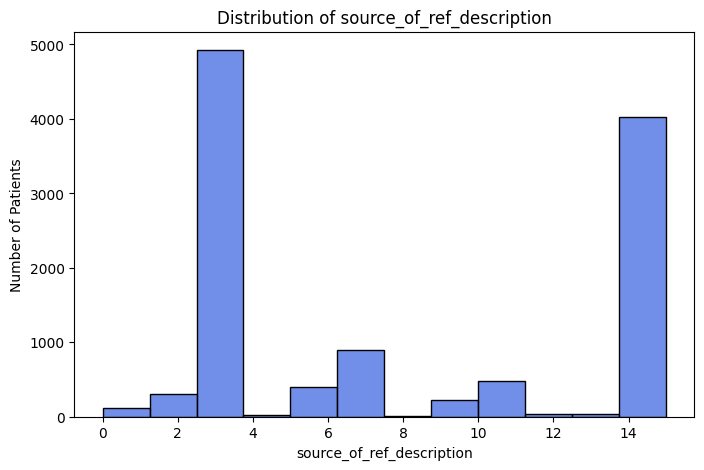

In [56]:
print(df_my["source_of_ref_description"].unique())
print(df_my["source_of_ref_description"].describe())

le = LabelEncoder()

df_my["source_of_ref_description"] = df_my["source_of_ref_description"].fillna("Unknown")

df_my["source_of_ref_description"] = le.fit_transform(df_my["source_of_ref_description"])

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", label_mapping)

df_my[["source_of_ref_description", "source_of_ref_description"]].head(10)

df_my["source_of_ref_description"].dtype
plt.figure(figsize=(8,5))
sns.histplot(
    df_my[df_my["source_of_ref_description"] != 16]["source_of_ref_description"],
    bins=12,
    kde=False,
    color="royalblue"
)
plt.title("Distribution of source_of_ref_description")
plt.xlabel("source_of_ref_description")
plt.ylabel("Number of Patients")
plt.show()

[nan 'Back pain (BP)' 'Falls (FAL)' 'Unwell adult (GU/UA)'
 'Abdominal pain adult (AP)' 'Eye problems (OPTH)' 'Collapsed adult (C?C)'
 'Diarrhoea and vomiting (DandV)' 'GI bleeding (GIB)'
 'Shortness of breath in adults (SOB)' 'Chest pain (CP)'
 'Limb problems (LP)' 'Sore throat (ENT)' 'Headache (HA)'
 'Urinary problems (ROU)' 'Abdominal pain child (AP)'
 'Bites and stings (ST)' 'Fits (F)' 'Facial problems (FP)'
 'Shortness of breath in children (SOB)' 'Overdose and poisoning (IOT)'
 'Palpitations (PALPS)' 'Abscess and local infections (ABS)'
 'Unwell child (GU/UC)' 'Unwell baby [up to 12 months] (UC)'
 'Asthma (AST)' 'Head injury (HI)' 'Torso injury (TI)'
 'Unwell newborn [up to 28 days] (UC)' 'Diabetes (DIA)'
 'Major trauma (MT)' 'Testicular pain (TP)' 'PV bleeding (PVB)'
 'Allergy (AR)' 'Wounds (LAC)' 'Assault (ASS)' 'Rashes (DERM)'
 'Pregnancy (/40)' 'Limping child (LC)' 'Behaving strangely (BS)'
 'Mental illness (PSY)' 'Ear problems (ENT)' 'Worried parent (BAB)'
 'Crying baby (BAB

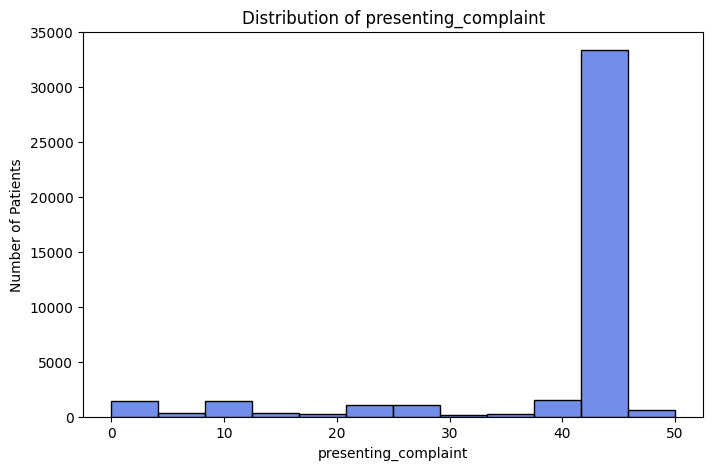

In [57]:
print(df_my["presenting_complaint"].unique())
print(df_my["presenting_complaint"].describe())

le = LabelEncoder()

df_my["presenting_complaint"] = df_my["presenting_complaint"].fillna("Unknown")

df_my["presenting_complaint"] = le.fit_transform(df_my["presenting_complaint"])

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", label_mapping)

df_my[["presenting_complaint", "presenting_complaint"]].head(10)

df_my["presenting_complaint"].dtype
plt.figure(figsize=(8,5))
sns.histplot(
    df_my[df_my["presenting_complaint"] != 16]["presenting_complaint"],
    bins=12,
    kde=False,
    color="royalblue"
)
plt.title("Distribution of presenting_complaint")
plt.xlabel("presenting_complaint")
plt.ylabel("Number of Patients")
plt.show()

[nan  1.  0.  2.  3.  5.  7.  9.  8.  6.  4. 12. 10. 14. 11. 13. 15. 17.
 16.]
count    9750.000000
mean        1.818564
std         2.387784
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max        17.000000
Name: NEWS2, dtype: float64


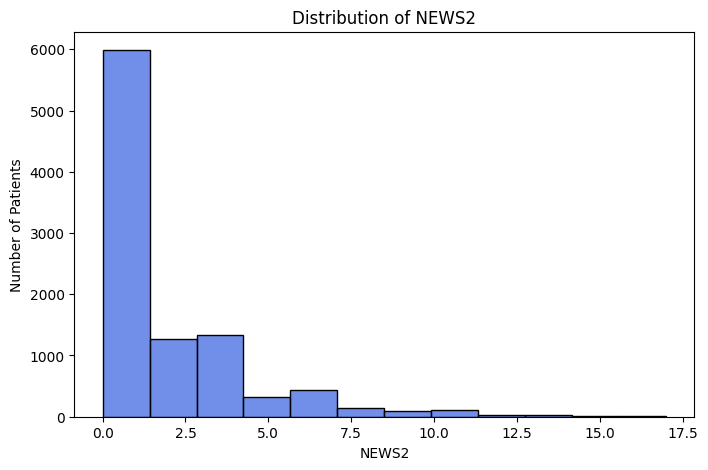

In [64]:
print(df_my["NEWS2"].unique())
print(df_my["NEWS2"].describe())

df_my["NEWS2"].dtype
plt.figure(figsize=(8,5))
sns.histplot(
    data=df_my,
    x="NEWS2",
    bins=12,
    kde=False,
    color="royalblue"
)
plt.title("Distribution of NEWS2")
plt.xlabel("NEWS2")
plt.ylabel("Number of Patients")
plt.show()

[3 0 1 4 2]
count    41846.000000
mean         2.212661
std          1.308762
min          0.000000
25%          1.000000
50%          3.000000
75%          3.000000
max          4.000000
Name: attend_dis_description, dtype: float64
Label mapping: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4)}


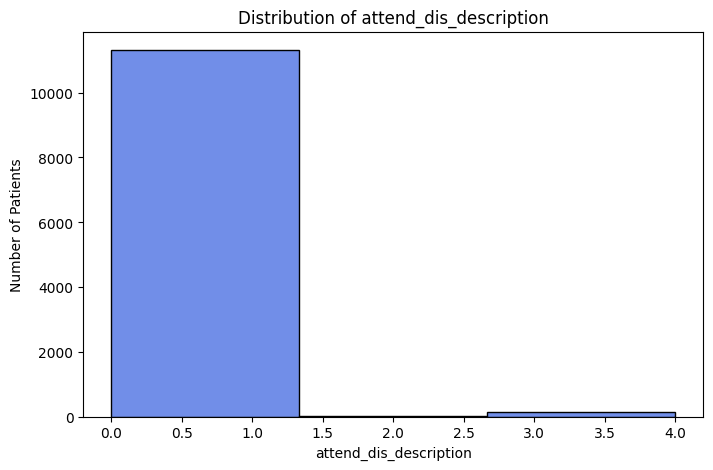

In [70]:
print(df_my["attend_dis_description"].unique())
print(df_my["attend_dis_description"].describe())

le = LabelEncoder()

df_my["attend_dis_description"] = df_my["attend_dis_description"].fillna("Unknown")

df_my["attend_dis_description"] = le.fit_transform(df_my["attend_dis_description"])

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", label_mapping)

df_my[["attend_dis_description", "attend_dis_description"]].head(10)

df_my["attend_dis_description"].dtype

plt.figure(figsize=(8,5))
sns.histplot(
    data=df_my[df_my["attend_dis_description"] != 3],  
    x="attend_dis_description",
    bins=3,
    kde=False,
    color="royalblue"
)
plt.title("Distribution of attend_dis_description")
plt.xlabel("attend_dis_description")
plt.ylabel("Number of Patients")
plt.show()

In [75]:
df_my["ae_unplanned_attendance"] = df_my["ae_unplanned_attendance"].fillna(0)

df_my["ae_unplanned_attendance"] = df_my["ae_unplanned_attendance"].astype(int)

print(df_my["ae_unplanned_attendance"].unique())
print(df_my["ae_unplanned_attendance"].describe())


[0 1]
count    41846.000000
mean         0.273957
std          0.445992
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: ae_unplanned_attendance, dtype: float64


[nan 'ECC Awaiting Triage' 'Majors Awaiting Triage'
 'Paediatrics Awaiting Triage']
count                      11464
unique                         3
top       Majors Awaiting Triage
freq                        5461
Name: location, dtype: object
Label mapping: {'ECC Awaiting Triage': np.int64(0), 'Majors Awaiting Triage': np.int64(1), 'Paediatrics Awaiting Triage': np.int64(2), 'Unknown': np.int64(3)}


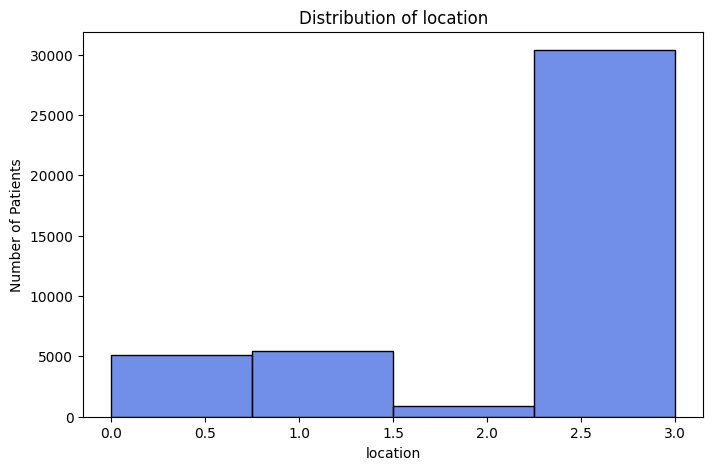

In [74]:
print(df_my["location"].unique())
print(df_my["location"].describe())

le = LabelEncoder()

df_my["location"] = df_my["location"].fillna("Unknown")

df_my["location"] = le.fit_transform(df_my["location"])

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", label_mapping)

df_my[["location", "location"]].head(10)

df_my["location"].dtype

plt.figure(figsize=(8,5))
sns.histplot(
    data=df_my,
    x="location",
    bins=4,
    kde=False,
    color="royalblue"
)
plt.title("Distribution of location")
plt.xlabel("location")
plt.ylabel("Number of Patients")
plt.show()